In [1]:
import rioxarray as rxr
import pandas as pd
import os
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
IDir = r'/Volumes/PhD/imagery/masters/output/MSM1/'
ODir = r'/Volumes/PhD/imagery/masters/output/ROC/design_storm/'

In [3]:
def MSM1_stats(basin, RI, image, plot = False):
    
    i_flat = image.values.flatten()
    pixarr = np.empty((i_flat.shape[0]), dtype= float)
    pixarr[:] = np.nan
    x = np.where(np.isnan(i_flat) == False)
        
    
    i_data = i_flat[x]
    mean_value = np.nanmean(i_data)
    median_value = np.nanmedian(i_data)
    kde = gaussian_kde(i_data)

    
    x_grid = np.linspace(i_data.min(), i_data.max(), 1000)

    
    kde_values = kde(x_grid)
   
    peak_index = kde_values.argmax()  
    peak_frequency = x_grid[peak_index]
    
    valid_data = i_flat[~np.isnan(i_flat)]

   
    percent_above_0_5 = np.sum(valid_data > 0.5) / len(valid_data) 
    percent_above_0_9 = np.sum(valid_data > 0.9) / len(valid_data) 

    basin_list.append(basin)
    RI_list.append(RI)
    mean_list.append(mean_value)
    median_list.append(median_value)
    peak_frequency_list.append(peak_frequency)
    above_50.append(percent_above_0_5)
    above_90.append(percent_above_0_9)

    if plot == True:
        bin = np.arange(0, 1.05, 0.05)
        plt.figure(figsize=(10, 6))
        sns.histplot(valid_data, bins=bin, kde=True, alpha=.1)
        plt.axvline(x=mean_value, color='m', linestyle='--', label = f'Mean: {mean_value: .3f}')
        plt.axvline(x=median_value, color='b', linestyle='--', label = f'Median: {median_value: .3f}')
        plt.axvline(x=peak_frequency, color='y', linestyle='--', label = f'Peak Freq: {peak_frequency: .3f}')

        #plt.hist(valid_data, bins=bin, color='blue', alpha=0.7, edgecolor='black')  # Adjust bins as needed
        plt.title(f"Basin {basin} MSM1 Distribution")
        plt.xlabel("Probability")
        plt.ylabel("Frequency")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.legend(loc='best')
        #plt.show()
        plt.savefig(os.path.join(ODir, f'{basin}_MSM1_Dist.png'), dpi = 300)
        plt.close()
        
   




In [5]:
basin_list = []
RI_list = []
mean_list = []
median_list = []
peak_frequency_list = []
above_50 = []
above_90 = []

for filename in os.listdir(IDir):
    if filename.startswith("._"):
        print(f"Skipping file: {filename}")
        continue
    file = os.path.join(IDir, filename)
    basin = filename.split('_')
    RI = basin[2]
    RI = RI.split('.')
    RI = RI[0]
    RI = RI[0:2]
    basin = basin[0]
    image = rxr.open_rasterio(file)
    MSM1_stats(basin, RI, image, False)
    
    
    


In [7]:
MSM1_df = {
    'BASIN_ID': basin_list,
    'RI': RI_list,
    'MSM1_M': mean_list,
    'MSM1_D': median_list,
    'MSM1_P': peak_frequency_list,
    'MSM1_>50': above_50,
    'MSM1_>90': above_90
}
MSM1_df = pd.DataFrame(MSM1_df)
MSM1_df

,BASIN_ID,RI,MSM1_M,MSM1_D,MSM1_P,MSM1_>50,MSM1_>90
0,10009,12,0.240171,0.221695,0.200251,0.000000,0.000000
1,10009,16,0.414237,0.385938,0.346617,0.293333,0.000000
2,10009,20,0.604781,0.581024,0.531380,0.786667,0.000000
3,10009,24,0.763173,0.753687,0.710027,1.000000,0.066667
4,10009,28,0.870135,0.870993,0.944994,1.000000,0.400000
...,...,...,...,...,...,...,...
13883,9997,24,0.892331,0.912209,0.934131,1.000000,0.577485
13884,9997,28,0.953307,0.965646,0.975238,1.000000,0.916179
13885,9997,32,0.980401,0.987019,0.990935,1.000000,0.996589
13886,9997,36,0.991863,0.995162,0.996640,1.000000,1.000000


In [48]:
fig_out = r'/Volumes/PhD/output/design_storm/'

In [51]:

unique_basins = MSM1_df['BASIN_ID'].unique()
for basin in unique_basins:
    basin_data = MSM1_df[MSM1_df['BASIN_ID'] == basin]
    plt.figure(figsize=(10,6))
    sns.lineplot(x = basin_data['RI'], y = basin_data['MSM1_M'], label = 'MSM1 Mean')
    sns.lineplot(x = basin_data['RI'], y = basin_data['MSM1_D'], label = 'MSM1 Median')
    sns.lineplot(x = basin_data['RI'], y = basin_data['MSM1_P'], label = 'MSM1 Peak Frequency')
    sns.lineplot(x = basin_data['RI'], y = basin_data['MSM1_>50'], label = 'MSM1 Area > 50%')
    sns.lineplot(x = basin_data['RI'], y = basin_data['MSM1_>90'], label = 'MSM1 Area > 90%')

    plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
    plt.ylim(0,1)
    plt.ylabel('PFDF Probability')
    plt.xlabel('Rainfall Intensity')
    plt.legend(loc='best')
    plt.title(f'Basin {basin}')
    plt.savefig(os.path.join(fig_out, f'{basin}_pvis.png'), dpi=300)
    plt.close()
    


In [42]:
M1_model = pd.read_csv(r'/Volumes/PhD/imagery/masters/output/ROC/design_storm/M1P_all.csv', index_col=0)
M1_model

,BASIN_ID,RI,M1P_M,M1P_D,M1P_P
0,123,12,0.064164,0.056530,0.053738
1,123,16,0.086012,0.072894,0.068209
2,123,20,0.114390,0.093525,0.086222
3,123,24,0.150589,0.119245,0.108438
4,123,28,0.195711,0.150860,0.135529
...,...,...,...,...,...
13883,44339,24,0.534098,0.537882,0.551855
13884,44339,28,0.682302,0.686137,0.700119
13885,44339,32,0.800933,0.804148,0.815712
13886,44339,36,0.882871,0.885211,0.893524


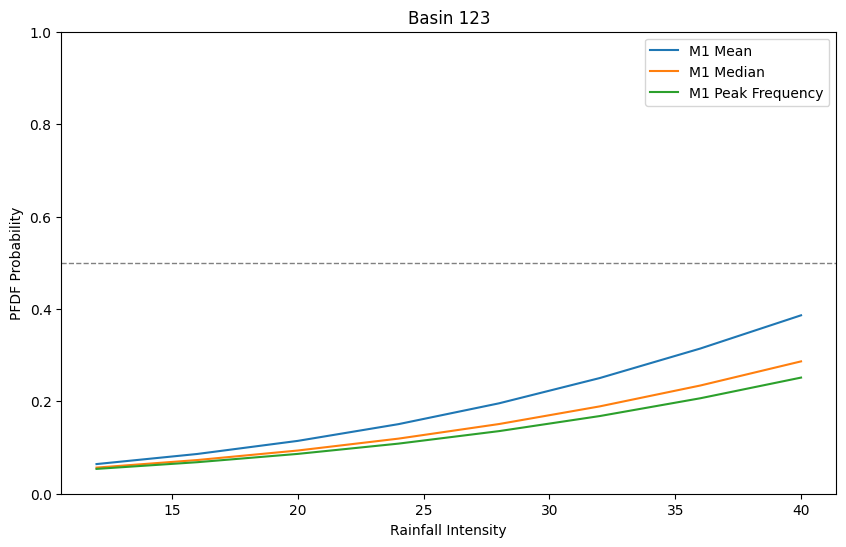

In [ ]:
unique_basins = M1_model['BASIN_ID'].unique()
for basin in unique_basins:
    basin_data = M1_model[M1_model['BASIN_ID'] == basin]
    plt.figure(figsize=(10,6))
    sns.lineplot(x = basin_data['RI'], y = basin_data['M1P_M'], label = 'M1 Mean')
    sns.lineplot(x = basin_data['RI'], y = basin_data['M1P_D'], label = 'M1 Median')
    sns.lineplot(x = basin_data['RI'], y = basin_data['M1P_P'], label = 'M1 Peak Frequency')

    plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
    plt.ylim(0,1)
    plt.legend(loc='best')
    plt.ylabel('PFDF Probability')
    plt.xlabel('Rainfall Intensity')
    plt.title(f'Basin {basin}')
    plt.savefig(os.path.join(fig_out, f'{basin}_M1_pvis.png'), dpi=300)
    break

In [11]:
df_12 = MSM1_df[MSM1_df['RI'] == 12]
df_12

,BASIN_ID,RI,MSM1P_Mean,MSM1P_Med,MSM1P_PF,MSM1_>50,MSM1_>90


In [6]:
MSM1_df.to_csv(os.path.join(ODir, 'MSM1_design-storm.csv'))

In [6]:
updated_df = pd.read_csv(r'/Volumes/PhD/imagery/masters/output/ROC/design_storm/MSM1_design-storm_edited.csv')
updated_df.drop(columns=['Unnamed: 0'], inplace=True)
updated_df

,BASIN_ID,RI,MSM1P_Mean,MSM1P_Med,MSM1P_PF,MSM1_>50,MSM1_>90
0,10009,12,0.240171,0.221695,0.200251,0.000000,0.000000
1,10048,12,0.136815,0.128381,0.120497,0.000000,0.000000
2,10058,12,0.229798,0.215690,0.214372,0.000000,0.000000
3,10060,12,0.234771,0.236290,0.239873,0.000000,0.000000
4,10104,12,0.270076,0.252555,0.247749,0.000000,0.000000
...,...,...,...,...,...,...,...
13883,9942,40,0.578477,0.552754,0.345974,0.514706,0.066176
13884,9959,40,0.997571,0.997986,0.998246,1.000000,1.000000
13885,9974,40,0.996828,0.998789,0.999022,1.000000,1.000000
13886,9985,40,0.970748,0.981729,0.986507,1.000000,0.973684


In [19]:
# Pivot the DataFrame
pivoted_df = updated_df.pivot(
    index='BASIN_ID',       # Each unique BASIN_ID as a row
    columns='RI',           # Each RI value becomes a column group
    values=['MSM1P_Mean', 'MSM1P_Med', 'MSM1P_PF', 'MSM1_>50', 'MSM1_>90']  # Metrics to organize
)

# Flatten the MultiIndex columns
pivoted_df.columns = ['{}_RI{}'.format(metric, int(ri)) for metric, ri in pivoted_df.columns]

# Reset index to bring BASIN_ID back as a column
pivoted_df = pivoted_df.reset_index()

# Display the final DataFrame
pivoted_df

# Save the result to a CSV if needed
pivoted_df.to_csv(os.path.join(ODir, 'MSM1_compact_design-storm.csv'), index=False)

In [20]:
pivoted_df

,BASIN_ID,MSM1P_Mean_RI12,MSM1P_Mean_RI16,MSM1P_Mean_RI20,MSM1P_Mean_RI24,MSM1P_Mean_RI28,MSM1P_Mean_RI32,MSM1P_Mean_RI36,MSM1P_Mean_RI40,MSM1P_Med_RI12,...,MSM1_>50_RI36,MSM1_>50_RI40,MSM1_>90_RI12,MSM1_>90_RI16,MSM1_>90_RI20,MSM1_>90_RI24,MSM1_>90_RI28,MSM1_>90_RI32,MSM1_>90_RI36,MSM1_>90_RI40
0,123,0.068145,0.094791,0.129986,0.173290,0.222621,0.275384,0.329658,0.384438,0.056530,...,0.187389,0.227612,0.0,0.0,0.0,0.000000,0.000063,0.000316,0.018846,0.062800
1,155,0.110949,0.174425,0.257951,0.352820,0.447686,0.535341,0.613690,0.683055,0.084037,...,0.517751,0.674556,0.0,0.0,0.0,0.000000,0.004438,0.093195,0.232249,0.334320
2,167,0.123761,0.198465,0.297309,0.409609,0.521182,0.622334,0.709075,0.780702,0.107684,...,0.792135,0.955056,0.0,0.0,0.0,0.000000,0.000000,0.123596,0.269663,0.365169
3,172,0.125566,0.202322,0.301807,0.410196,0.512555,0.601957,0.678192,0.743029,0.102787,...,0.652921,0.790378,0.0,0.0,0.0,0.000000,0.000000,0.211340,0.359107,0.412371
4,184,0.203214,0.350832,0.531211,0.700743,0.826702,0.905762,0.950531,0.974481,0.209799,...,1.000000,1.000000,0.0,0.0,0.0,0.000000,0.016260,0.715447,0.910569,0.975610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1731,44218,0.061878,0.082557,0.109481,0.143726,0.185919,0.235903,0.292565,0.353970,0.056792,...,0.091190,0.222566,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1732,44238,0.068688,0.094332,0.128274,0.171916,0.225962,0.289943,0.361966,0.438868,0.067951,...,0.105761,0.306931,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000450,0.001800
1733,44256,0.082278,0.118799,0.168485,0.233099,0.312403,0.403329,0.500167,0.595911,0.080229,...,0.402299,0.919540,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1734,44320,0.238439,0.402866,0.573418,0.715436,0.818857,0.888151,0.932223,0.959388,0.219513,...,1.000000,1.000000,0.0,0.0,0.0,0.223005,0.382629,0.610329,0.781690,0.880282
